# Field Failure Data Analysis

## Introduction

In [1]:
# Import relevant modules
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

## Utility functions

In [2]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file, this may take a while...\n')
        tuples = []

        for win in c_wins:
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ

#             print(str(win)+' '+str(tup))    
            tuples.append(tup)
        
        sens_file = open(filepath, 'w')
        
        for i in range(len(c_wins)):
            sens_file.write(str(c_wins[i]) + ' ' + str(tuples[i]) + '\n')
        
        sens_file.close()
    else:
        print('File already exists!\n')

In [3]:
def tupling(dataframe, c_win, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file, this may take a while...\n')
        
        tup = 0
        prev = int(dataframe.loc[0,'Timestamp'])
        dataframe.loc[0,'Tuple'] = 0

        for index in range(dataframe.shape[0]-1):
            succ = int(dataframe.loc[index+1,'Timestamp'])
            if  succ - prev >= c_win:
                tup = tup + 1
            dataframe.loc[index+1,'Tuple'] = tup
            prev = succ
            
        dataframe.to_csv(filepath)
        return dataframe
    else:
        print('File already exists!\n')
        dataframe = pd.read_csv(filepath, index_col = 0)
        return dataframe

# Mercury

In [4]:
# Load Mercury Data
df_mercury = pd.read_csv('Dataset/MercuryErrorLog.txt', names = ['Timestamp', 'Node', 'Subsystem', 'Message'])

df_mercury.loc[:,'Node'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[1]
df_mercury.loc[:,'Subsystem'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[2]
df_mercury.loc[:,'Message'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[3]
df_mercury.loc[:,'Timestamp'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

print('Log file has ' + str(df_mercury.shape[0]) + ' entries and ' + str(df_mercury.shape[1]) + ' columns.')
df_mercury.head()

Log file has 80854 entries and 4 columns.


Timestamp     Node Subsystem                             Message
0  1167637660  tg-c645       PRO  +BEGIN HARDWARE ERROR STATE AT CMC
1  1167637660  tg-c645       PRO           Device Error Info Section
2  1167637660  tg-c645       PRO                        Error Map: x
3  1167637720  tg-c645       PRO  +BEGIN HARDWARE ERROR STATE AT CMC
4  1167637720  tg-c645       PRO           Device Error Info Section

## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

File already exists!



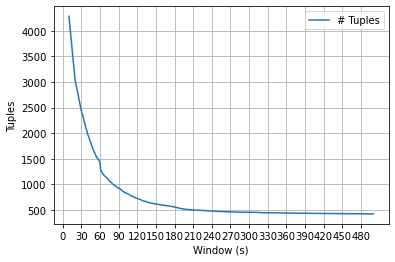

In [5]:
c_wins = np.arange(10,510,10)
accuracy = np.arange(50,150,1)
c_wins = c_wins.tolist()
c_wins.extend(accuracy)
c_wins.sort()

filepath = 'Dataset/MercurySensitivity.txt'
sensitivity_analysis(df_mercury, c_wins, filepath)

df_mercury_sensitivity = pd.read_csv(filepath, sep = ' ', names = ['Window', 'Tuples'])

plt.plot(df_mercury_sensitivity['Window'],df_mercury_sensitivity['Tuples'], label = '# Tuples')
plt.xticks(np.arange(0, 500, step = 30))
plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()

File already exists!



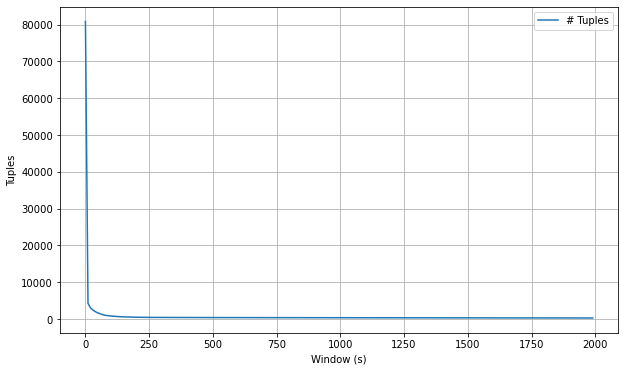

In [6]:
c_wins = np.arange(0,2000,10)

filepath = 'Dataset/MercurySensitivityAcc.txt'
sensitivity_analysis(df_mercury, c_wins, filepath)

df_mercury_sensitivity = pd.read_csv(filepath, sep = ' ', names = ['Window', 'Tuples'])

plt.figure(figsize=(10,6))

plt.plot(df_mercury_sensitivity['Window'],df_mercury_sensitivity['Tuples'], label = '# Tuples')

plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()

#### Tupling

In [7]:
window = 250
filepath = 'Dataset/MercuryData.csv'
df_mercury = tupling(df_mercury, window, filepath)

df_mercury = df_mercury.astype({'Timestamp' : 'int32', 'Tuple' : 'int32'})

df_mercury.head()

File already exists!



Timestamp     Node Subsystem                             Message  Tuple
0  1167637660  tg-c645       PRO  +BEGIN HARDWARE ERROR STATE AT CMC      0
1  1167637660  tg-c645       PRO           Device Error Info Section      0
2  1167637660  tg-c645       PRO                        Error Map: x      0
3  1167637720  tg-c645       PRO  +BEGIN HARDWARE ERROR STATE AT CMC      0
4  1167637720  tg-c645       PRO           Device Error Info Section      0

In [8]:
print('Number of tuples: ' + str(df_mercury.max(axis = 0).loc['Tuple'] + 1))

Number of tuples: 469


In [9]:
df_stat = pd.DataFrame(columns=['# Entries', 'Start time', 'End time', 'Length', 'Density', 'Interarrival'])

df_stat['# Entries'] = df_mercury.groupby(by='Tuple').count()['Timestamp']
df_stat['Start time'] =  df_mercury.groupby(by='Tuple').min(numeric_only = True)['Timestamp']
df_stat['End time'] =  df_mercury.groupby(by='Tuple').max(numeric_only = True)['Timestamp']
df_stat['Length'] =  df_stat['End time'] - df_stat['Start time']
df_stat['Density'] = df_stat['# Entries'] / df_stat['Length']
df_temp = pd.DataFrame(data = {'Start time' : [np.nan]})
df_temp = df_temp.append(df_stat, ignore_index = True)
df_stat['Interarrival'] = (df_stat['Start time'] - df_temp['End time']).dropna().astype(int)
df_stat['Interarrival']
df_stat.head()

# Entries  Start time    End time  Length   Density  Interarrival
Tuple                                                                   
0              6  1167637660  1167637720      60  0.100000           NaN
1              3  1167655228  1167655229       1  3.000000       17508.0
2             75  1167657137  1167657550     413  0.181598        1908.0
3              2  1167657941  1167657941       0       inf         391.0
4             27  1167658201  1167658456     255  0.105882         260.0

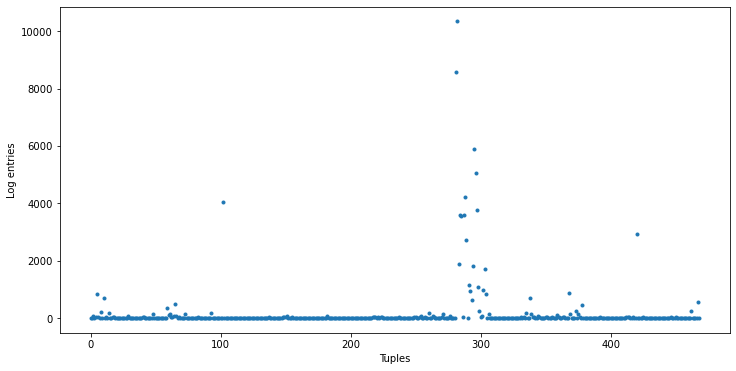

In [10]:
x = df_stat.index
y = df_stat['# Entries']

plt.figure(figsize=(12,6))

plt.scatter(x, y, marker = '.')

plt.xlabel('Tuples')
plt.ylabel('Log entries')
plt.show()

### Spatial coalescence

In [11]:
df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'

In [12]:
print('Number of nodes that generates error: ' + str(len(df_mercury['Node'].unique())))

Number of nodes that generates error: 53


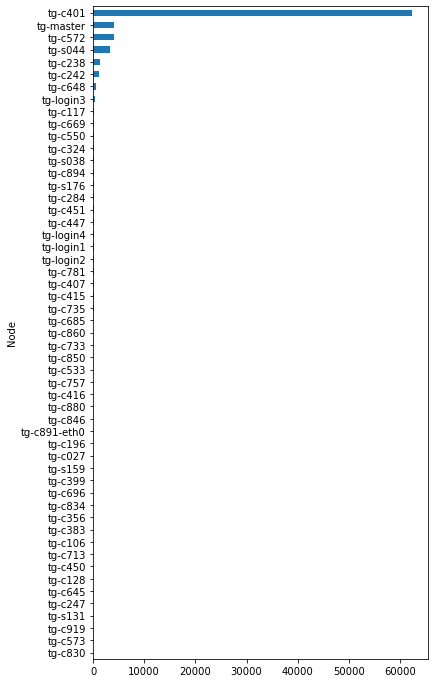

In [13]:
plt.figure(figsize=(6,12))
df_mercury.groupby(by='Node').Timestamp.count().sort_values().plot.barh()
plt.show()

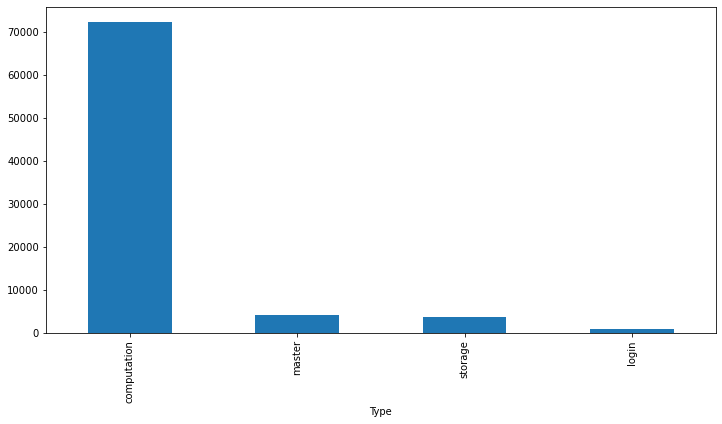

In [14]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

### Content-based coalescence

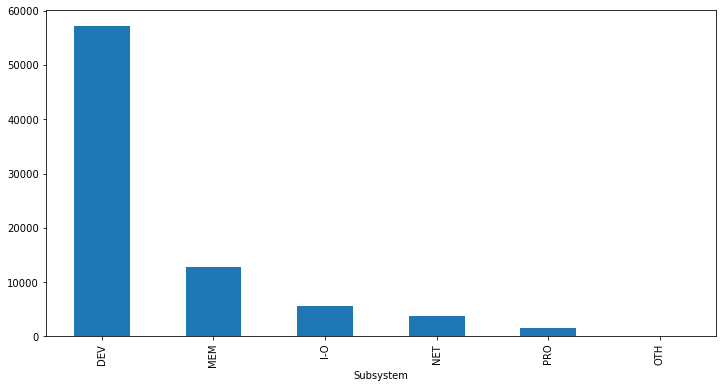

In [15]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

### Truncation analysis

In [33]:
q = df_stat['Interarrival'].quantile(q=0.1)
print("0.1 Quantile: " + str(q))

0.1 Quantile: 491.90000000000003


In [34]:
df_group = df_mercury.groupby(by=['Tuple','Node']).count()

df_group.tail()

Timestamp  Subsystem  Message  Type
Tuple Node                                          
466   tg-master          4          4        4     4
467   tg-c128            2          2        2     2
      tg-c196            2          2        2     2
      tg-master        558        558      558   558
468   tg-c196            2          2        2     2

In [35]:
df_trunc = df_stat.loc[df_stat['Interarrival'] <= q]

df_trunc.head()

# Entries  Start time    End time  Length   Density  Interarrival
Tuple                                                                   
3              2  1167657941  1167657941       0       inf         391.0
4             27  1167658201  1167658456     255  0.105882         260.0
5            825  1167658913  1167665307    6394  0.129027         457.0
6             22  1167665787  1167665982     195  0.112821         480.0
9             17  1167669001  1167669463     462  0.036797         377.0

In [50]:
df_group = df_group.reset_index(level = 1)

truncated = 0
for tup in df_trunc.index:

    df_tup = df_group.loc[df_group.index == tup]    
#     node = df_tup.max()['Node']
    node = df_tup.loc[df_tup['Timestamp'] == df_tup.max()['Timestamp']].iloc[0]['Node']
#     print('Tupla: ', tup, '\n', 'Node: ', node)
    
    df_tup_prec = df_group.loc[df_group.index == tup-1]
#     node_prec = df_tup_prec.max()['Node']
    node_prec = df_tup_prec.loc[df_tup_prec['Timestamp'] == df_tup_prec.max()['Timestamp']].iloc[0]['Node']
#     print('Tupla prec.: ', tup-1, '\n', 'Node: ', node_prec)
    
    if node == node_prec:
#         print('Truncation detected')
        truncated = truncated +1
    
    
#     print('\n\n')

In [69]:
num_tuple = df_mercury.max(axis = 0).loc['Tuple'] + 1
perc_trunc = (truncated/num_tuple)*100

print('Estimate percentage of truncation: ', perc_trunc)

Estimate percentage of truncation:  8.102345415778252


In [70]:
collided = 0
for tup in df_group.index.unique():
    if df_group.loc[df_group.index == tup].shape[0] > 1:
        collided = collided + 1


In [71]:
perc_coll = (collided/num_tuple)*100

print('Estimate percentage of collision: ', perc_coll)

Estimate percentage of collision:  10.874200426439232
